# INM702 Coursework Task 3
### Aaron Mir (Student Number: 160001207)

The third task is about comparing your results with architectures developed using PyTorch. 

    • Compare the results obtained in Task 2 to the results obtained using the same architectures implemented in PyTorch.
    
    • Then, propose improvements and new architectures that make use of more advanced methods (e.g. Convolutional Neural Networks, dropout, ...).

    • Compare the results. 

    • Finally, present the confusion matrix of your best model.


In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import time as t
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Sklearn Version: 0.23.1


In [ ]:
##--------------------Coding References---------------------##
# Percentage of borrowed code: 10% - confusion matrix plot function from scikit learn website and initialisation of the prediction and label tensors when testing the models.
# [1] Sathyan, A. (2019) Confusion matrix and test accuracy for PyTorch Transfer Learning tutorial, Available at: https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial (Accessed: 18 December 2020).
# [2] Sci-kit Learn (2019) Confusion Matrix Plot Function, Available at: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html (Accessed: 17 December 2016).

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())
torch.cuda.empty_cache()

cuda:0
GeForce GTX 1080
0
0


In [14]:
def MNIST_load(batch_size):
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = datasets.MNIST(root='./dataTask3', train=True, download=True, transform=trans)
    test_set = datasets.MNIST(root='./dataTask3', train=False, download=True, transform=trans)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    return train_set, test_set, train_loader, test_loader

In [15]:
train_set, test_set, train_loader, test_loader = MNIST_load(64)

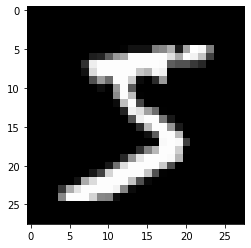

In [16]:
plt.imshow(train_set[0][0][0], cmap='gray');

In [17]:
print(len(train_loader))
print(len(test_loader))

938
157


In [18]:
for i, (images, labels) in enumerate(train_loader):           # checking to see if the data  is in the right format
    print(i, images.size(), len(labels))
    break

0 torch.Size([64, 1, 28, 28]) 64


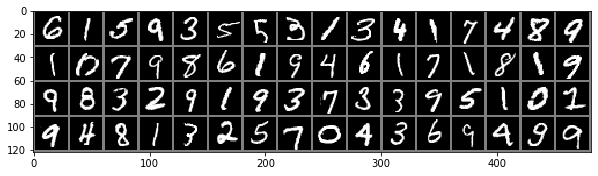

In [19]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)                               # pulls one batch from the loader
images, labels = dataiter.next()                            # pulls out 64 images for one batch
imshow(torchvision.utils.make_grid(images, nrow=16))
images = images.to(device)
labels = labels.to(device)

In [25]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 64)             # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)              # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                       # flattens the tensor
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network"

In [26]:
model = Neural_Network().to(device)
optimiser = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [27]:
epochs = 10
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):      # for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.432038
epoch: 1, train loss: 0.223721
epoch: 2, train loss: 0.168232
epoch: 3, train loss: 0.140094
epoch: 4, train loss: 0.124126
epoch: 5, train loss: 0.108922
epoch: 6, train loss: 0.102207
epoch: 7, train loss: 0.093009
epoch: 8, train loss: 0.083643
epoch: 9, train loss: 0.081622
Training has taken  98.27565264701843 seconds to complete


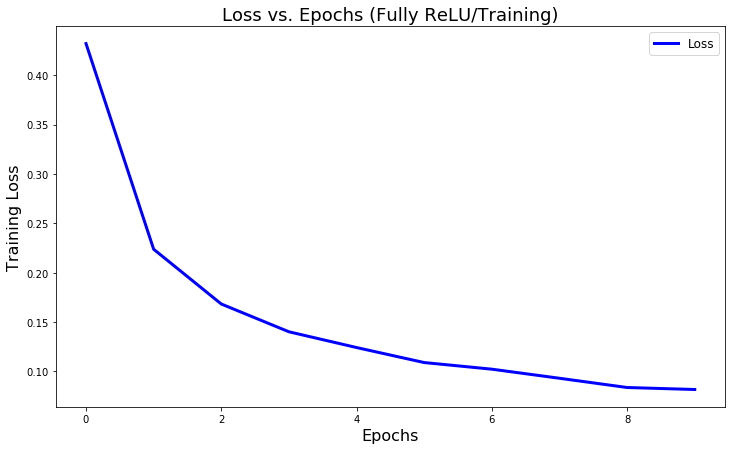

In [28]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully ReLU/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [29]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 965    0    3    1    0    2    7    1    1    0]
 [   0 1112    7    3    0    2    3    0    8    0]
 [   4    0 1012    2    0    1    3    6    4    0]
 [   0    0    7  992    1    0    0    3    4    3]
 [   1    0    5    1  937    2   19    0    1   16]
 [   3    2    1   19    1  849    9    0    6    2]
 [   5    2    2    1    1    3  941    0    3    0]
 [   1    5   24    2    1    1    2  980    1   11]
 [   2    1    9    4    0    6    5    5  941    1]
 [   2    5    1    6    8    6    3    5    9  964]]
[98.46938776 97.97356828 98.0620155  98.21782178 95.41751527 95.1793722
 98.22546973 95.3307393  96.61190965 95.54013875]
              precision    recall  f1-score   support

           0      0.982     0.985     0.983       980
           1      0.987     0.980     0.983      1135
           2      0.945     0.981     0.962      1032
           3      0.962     0.982     0.972      1010
           4      0.987     0.954   

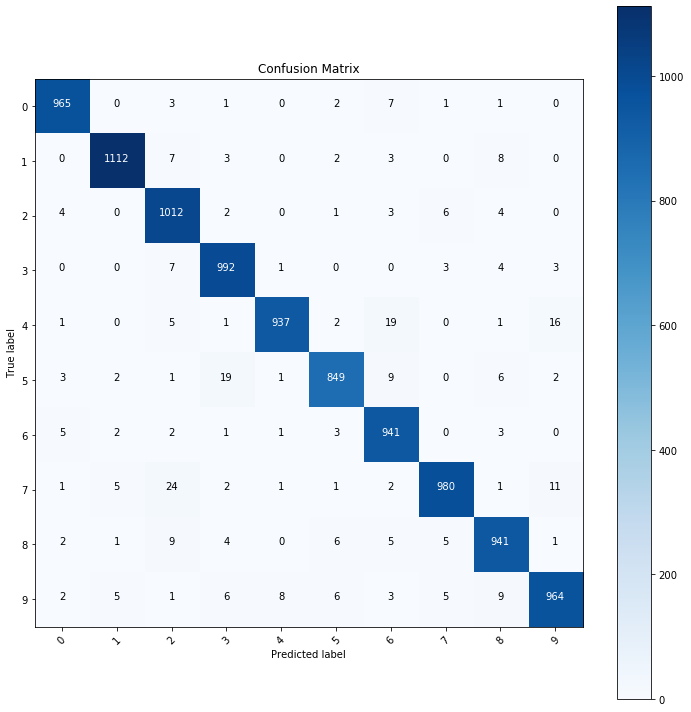

In [57]:
nb_classes = 9
# Initialize the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        _, preds = torch.max(y_pred, 1)
        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cpu()])
        label_list=torch.cat([label_list,y.view(-1).cpu()])
# Confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# Per-class accuracy
class_accuracy=100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

In [31]:
#------------------------------------------- Main Neural Network (Fully Sigmoid) --------------------------------#
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                     # flattens the tensor
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network2"

In [32]:
model2 = Neural_Network2().to(device)
optimiser = optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [33]:
epochs = 10
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model2.train()
    for batch_idx, (X, y) in enumerate(train_loader):      #for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model2(X) # X.view(-1, 784)
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.769446
epoch: 1, train loss: 0.253153
epoch: 2, train loss: 0.182344
epoch: 3, train loss: 0.147923
epoch: 4, train loss: 0.124737
epoch: 5, train loss: 0.108291
epoch: 6, train loss: 0.098243
epoch: 7, train loss: 0.088621
epoch: 8, train loss: 0.079860
epoch: 9, train loss: 0.073837
Training has taken  98.07481551170349 seconds to complete


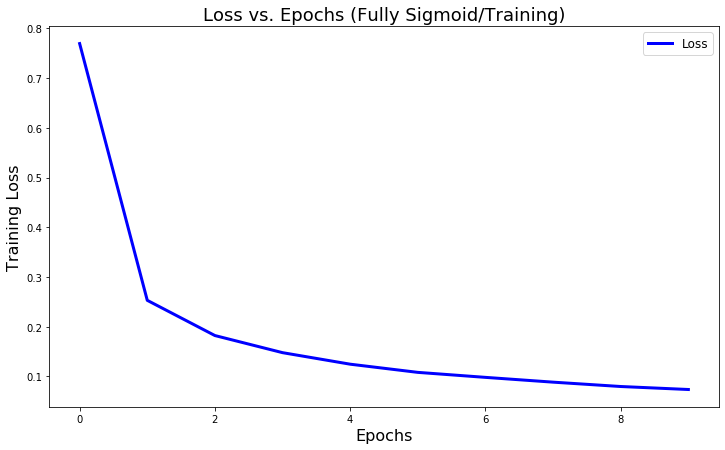

In [34]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully Sigmoid/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[ 965    0    2    2    0    2    2    3    2    2]
 [   0 1118    3    6    0    1    0    1    6    0]
 [   5    0 1004    6    3    1    1    7    5    0]
 [   0    0    4  993    0    0    0    6    5    2]
 [   1    0    4    2  923    0    4    5    4   39]
 [   5    1    1   34    4  826    5    3    9    4]
 [   7    3    4    0    6    3  926    0    9    0]
 [   1    2   13    9    0    1    0 1002    0    0]
 [   3    0    6   13    3    2    2    6  938    1]
 [   4    1    1   15    7    2    0   20   10  949]]
[98.46938776 98.50220264 97.28682171 98.31683168 93.99185336 92.60089686
 96.65970772 97.47081712 96.30390144 94.05351833]
              precision    recall  f1-score   support

           0      0.974     0.985     0.979       980
           1      0.994     0.985     0.989      1135
           2      0.964     0.973     0.968      1032
           3      0.919     0.983     0.950      1010
           4      0.976     0.940  

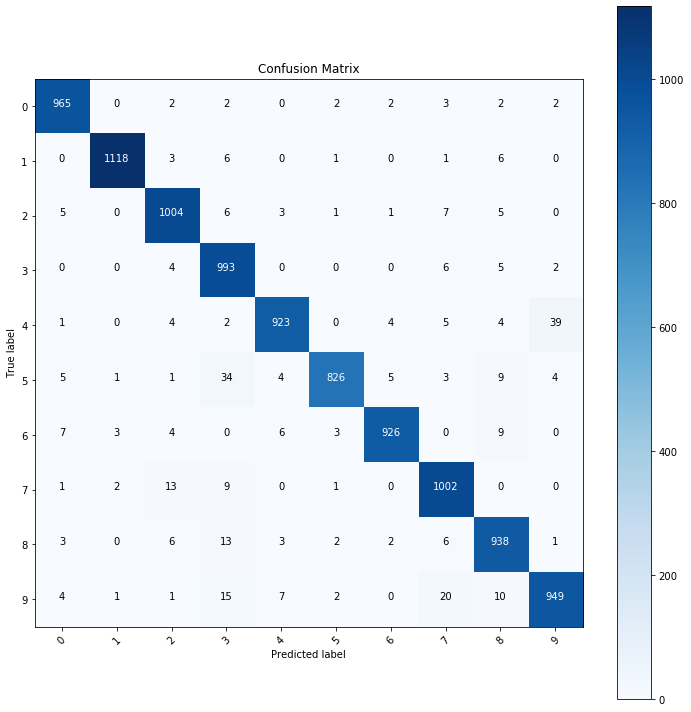

In [35]:
nb_classes = 9
# initialise the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model2.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model2(X)
        _, preds = torch.max(y_pred, 1)
        # append batch prediction results
        pred_list = torch.cat([pred_list,preds.view(-1).cpu()])
        label_list = torch.cat([label_list,y.view(-1).cpu()])
# confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# per-class accuracy
class_accuracy = 100 * cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

In [36]:
#------------------------------------------- Main Neural Network (CNN) --------------------------------#
class Neural_Network3(nn.Module):
    def __init__(self):
        super(Neural_Network3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, X):
        X = self.pool1(F.relu(self.bn1(self.conv1(X))))
        X = self.pool2(F.relu(self.bn2(self.conv2(X))))
        X = X.view(-1, 64*6*6)
        X = self.fc1(X)
        X = self.drop(X)
        X = self.fc2(X)
        X = self.fc3(X)   
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network3"

In [37]:
model3 = Neural_Network3().to(device)
optimiser = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [38]:
epochs = 8
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model3.train()
    for batch_idx, (X, y) in enumerate(train_loader):      # for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model3(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.168505
epoch: 1, train loss: 0.072408
epoch: 2, train loss: 0.056936
epoch: 3, train loss: 0.047853
epoch: 4, train loss: 0.037602
epoch: 5, train loss: 0.032655
epoch: 6, train loss: 0.028995
epoch: 7, train loss: 0.026013
Training has taken  103.9874210357666 seconds to complete


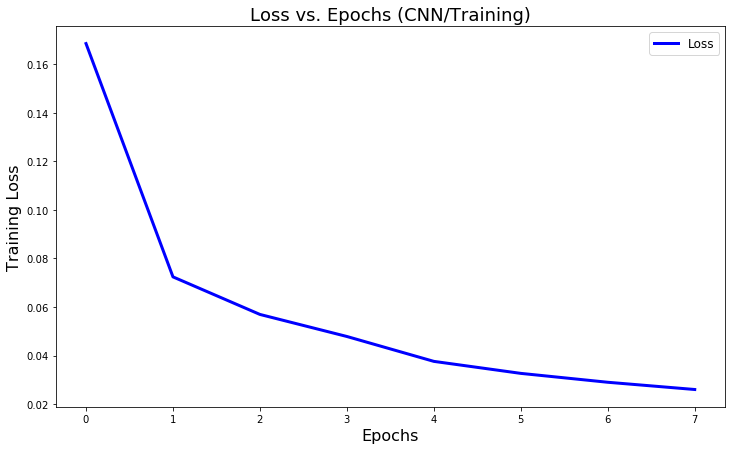

In [39]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (CNN/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[ 975    1    2    0    0    0    1    1    0    0]
 [   0 1125    2    3    0    0    0    4    1    0]
 [   1    0 1021    1    5    0    0    3    1    0]
 [   0    0    0  996    0   13    0    0    1    0]
 [   0    1    0    0  976    0    2    1    0    2]
 [   0    0    0    2    0  888    2    0    0    0]
 [   4    6    0    0    1    2  945    0    0    0]
 [   0    1    6    0    0    0    0 1019    1    1]
 [   7    0    2    0    1    2    5    0  957    0]
 [   0    0    0    2   18    6    0    6    3  974]]
[99.48979592 99.11894273 98.93410853 98.61386139 99.38900204 99.55156951
 98.64300626 99.12451362 98.25462012 96.53121903]
              precision    recall  f1-score   support

           0      0.988     0.995     0.991       980
           1      0.992     0.991     0.992      1135
           2      0.988     0.989     0.989      1032
           3      0.992     0.986     0.989      1010
           4      0.975     0.994  

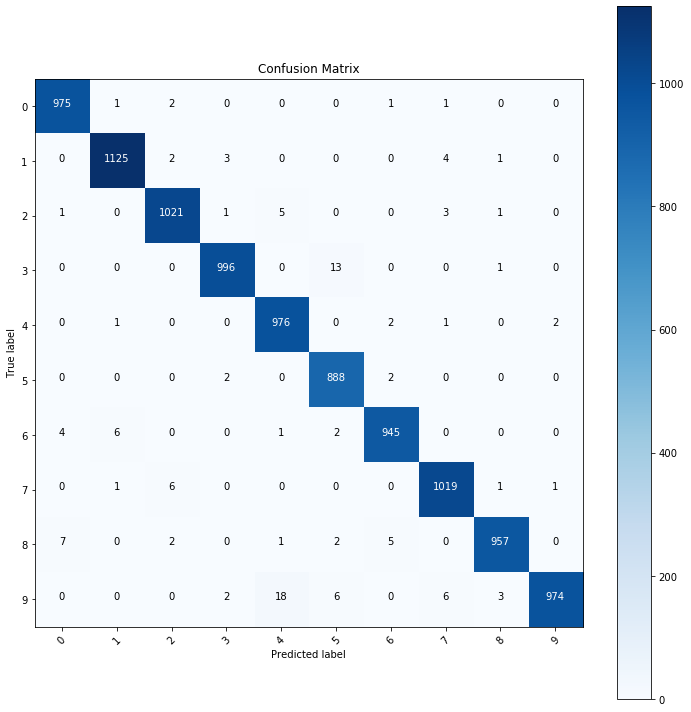

In [35]:
nb_classes = 9
# initialise the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model3.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model3(X)
        _, preds = torch.max(y_pred, 1)
        # append batch prediction results
        pred_list = torch.cat([pred_list,preds.view(-1).cpu()])
        label_list = torch.cat([label_list,y.view(-1).cpu()])
# confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# per-class accuracy
class_accuracy = 100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))